In [558]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [559]:
# packages to use
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

## Mini Project 4

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project, I will explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. I will also explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy.

Below is some code that calculates the price of a call option, calculates the appropriate delta of a call option, and simulates a stock path whose $\sigma$ is not constant.

Alternative options include: stock paths simulated by Heston model? GARCH model for volatility?

In [560]:
def bs_call(S0, K, sigma, t, r = 0):
    """
    Computes the Black-Scholes price of a European call option.

    Parameters:
        S0 (float): Current asset price
        K (float): Strike price
        sigma (float): Annualized volatility (standard deviation of log returns)
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)

    Returns:
        float: Call option price
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    call_price = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call_price

In [561]:
def bs_call_delta(S0, K, sigma, t, r):
    """
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate

    Returns:
        float: Delta of Call Option
    """
    d1 = (np.log(S0/K) + (r+.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)

In [562]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    #paths
    paths = S0*np.exp(log_returns)
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    return paths

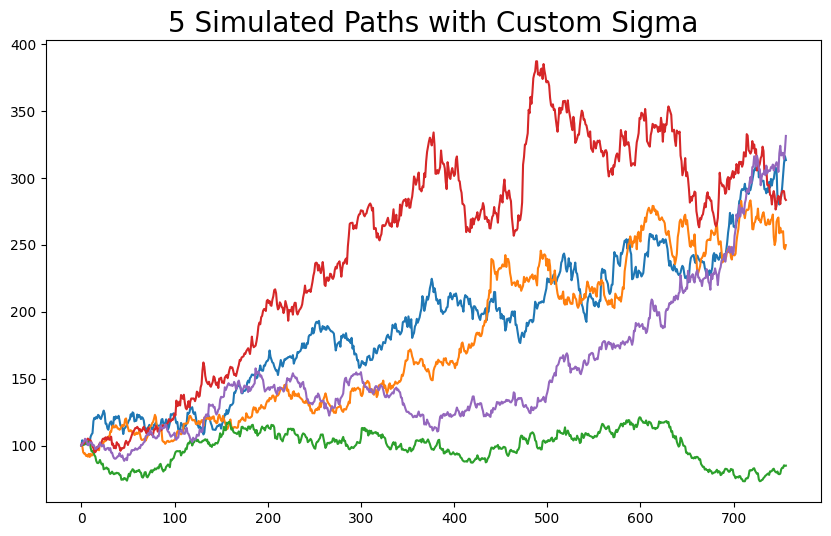

In [563]:
#First, check that code works as predicted
#let's simulate 5 paths of daily steps over 3-year period for non constant volatility
S0 = 100
t = 3
r = 0.039
mu = 0.275
n_paths = 5
n_steps = t*252

#notice how I do not pass sigma here... instead the volatility changes in the function
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)

plt.figure(figsize = (10,6))
for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)
plt.show()

#### What is the volatility of the stocks above?
Well, we'd expect to see the volatility of each stock path as $\sigma = 0.5*.2 + 0.3*.3 + 0.2*.45 = 0.28$ (based on the probabilities from the function above). Below, I calculate the observed volatilities of each stock path movement.

In [564]:
#calculate volatility of each path movement
prices = simulated_paths
# 1) log-prices  →  log-returns  (vectorised across rows)
log_returns = np.diff(np.log(prices), axis=1)
# 2) per-period σ for each row (path)
sigma  = log_returns.std(axis=1, ddof=1) * np.sqrt(252)

In [565]:
print(r"Annualised $\sigma$ for the 5 paths")
print(sigma)

Annualised $\sigma$ for the 5 paths
[0.31590451 0.30237254 0.28892987 0.31448139 0.28441036]


In [566]:
print(f'The mean +/- stdev of calculated volatility is {np.mean(sigma):.3f} +/- {np.std(sigma):.3f}')

The mean +/- stdev of calculated volatility is 0.301 +/- 0.013


In [567]:
sigma = .5*.2 + .3*.3 + .2*.45
print(f'Expected sigma value is {sigma:.2f}')

Expected sigma value is 0.28


So, we do see stock path movements with this function that have dynamic volatility of what we should expect.

### How does dynamic volatility affect outcomes without hedging
First, let's just do the dumb thing of not hedging and see what happens to the distribution of payouts. The only thing is we need to know what $\sigma$ is in order to price the option. Therefore, I'll try three seperate cases: 1) assume high $\sigma$, 2) assume low $\sigma$ and 3) assume the expected $\sigma$. Assuming a high value of $\sigma$ will make the option expensive whereas assuming a low value of $\sigma$ will make the option cheaper.

In [568]:
# --- option & market setup ---------------------------------------------------
S0     = 35          # spot price
K      = 37.50       # strike
r      = 0.039       # risk-free rate
t      = 1           # years to expiry
mu     = 0           # drift
options_sold = 100

sigmas   = [0.20, 0.28, 0.45]   # <- three scenarios of sigma, max, min, and expected value used to price the option
n_paths  = 10000
n_steps  = 252

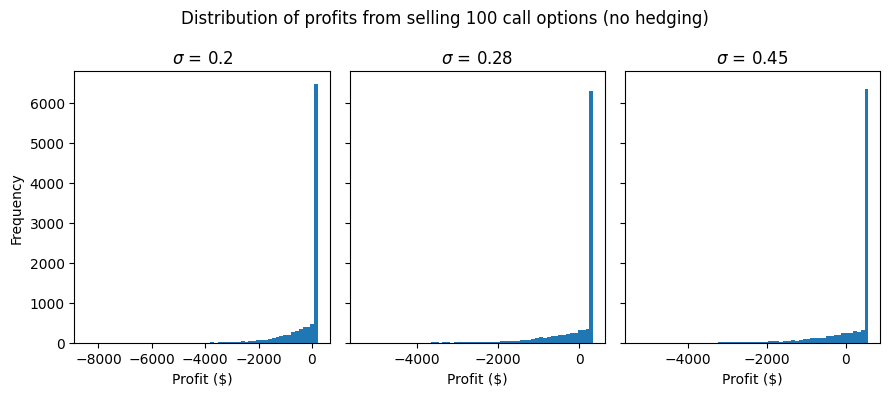

In [569]:
# --- run the three simulations ---------------------------------------------
results = []                          # hold rows for the summary table
fig, axes = plt.subplots(1, 3, figsize=(9, 4), sharey=True)

for j, sigma in enumerate(sigmas):
    # Black-Scholes premium (time-0)
    premium = bs_call(S0, K, sigma, t, r)

    # Simulate end-of-year prices
    paths       = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)
    end_points  = paths[:, -1]

    # Payoff of ONE long call, then P&L of selling 100 calls
    call_payouts  = np.maximum(end_points - K, 0)
    call_values   = np.exp(-r * t) * call_payouts
    profits       = options_sold * (-call_values + premium)

    # --- stats for the table
    expected   = profits.mean()
    std_err    = profits.std(ddof=1) / np.sqrt(n_paths)
    max_loss   = profits.min()
    max_profit = profits.max()

    results.append(
        [sigma, premium, expected, std_err, max_loss, max_profit]
    )

    # --- histogram subplot
    ax = axes[j]
    ax.hist(profits, bins=60)
    ax.set_title(rf"$\sigma$ = {sigma}")
    ax.set_xlabel("Profit ($)")
    if j == 0:
        ax.set_ylabel("Frequency")

fig.suptitle("Distribution of profits from selling 100 call options (no hedging)")
plt.tight_layout()
plt.show()

In [570]:
# --- summary table ---------------------------------------------------
cols = [r"$\sigma$", "BS Price", "Expected Profit", "Std Error",
        "Max Loss", "Max Profit"]

summary = pd.DataFrame(results, columns=cols)

print("\nSummary statistics:")
print(summary.to_string(index=False, float_format="{:,.2f}".format))


Summary statistics:
 $\sigma$  BS Price  Expected Profit  Std Error  Max Loss  Max Profit
     0.20      2.33          -129.33       6.71 -8,465.64      232.92
     0.28      3.45           -15.84       6.75 -5,372.77      344.59
     0.45      5.81           214.95       6.83 -5,322.90      580.66


So, when volatility is changing, we need to assume some constant level of volatility in order to price the option. In the case where we assume the max volatility, the option is expensive and we are expected to make a profit (as we priced the option as more volatile than it actually is). However, when we assume the min volatility, the option is undervalued and we generally lose money. In the case where we priced the option as some weighted sum of the volatility values (like an expected value), we find that we generally lose money, but not much -- we are right around $0 in return.

Let's see how this plays out as a function of the volatility we use to price the option...

In [571]:
# --- option & market setup ---------------------------------------------------
S0     = 35          # spot price
K      = 37.50       # strike
r      = 0.039       # risk-free rate
t      = 1           # years to expiry
mu     = 0           # drift
options_sold = 100

sigmas   = np.linspace(0.1,0.55,21) # <- constant sigmas used to price the option contract
n_paths  = 1000 #only use 1000 paths to speed up simulation time
n_steps  = 252

In [572]:
# --- run the simulations ---------------------------------------------
results = []                          # hold rows for the summary table

for sigma in sigmas:
    # Black-Scholes premium (time-0)
    premium = bs_call(S0, K, sigma, t, r)

    # Simulate end-of-year prices
    paths       = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)
    end_points  = paths[:, -1]

    # Payoff of ONE long call, then P&L of selling 100 calls
    call_payouts  = np.maximum(end_points - K, 0)
    call_values   = np.exp(-r * t) * call_payouts
    profits       = options_sold * (-call_values + premium)

    # --- stats for the table
    expected   = profits.mean()
    std_err    = profits.std(ddof=1) / np.sqrt(n_paths)
    max_loss   = profits.min()
    max_profit = profits.max()

    results.append(
        [sigma, premium, expected, std_err, max_loss, max_profit]
    )

results = np.asarray(results)

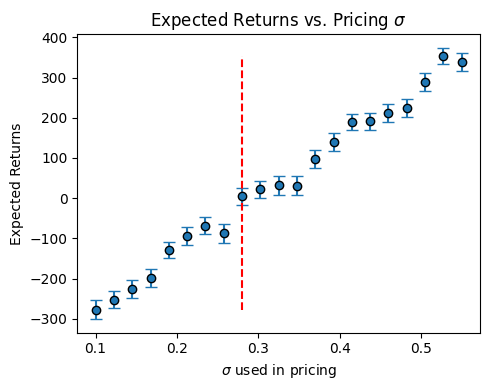

In [573]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.errorbar(sigmas, results[:,2], yerr=results[:,3], fmt='o', capsize=4, markeredgecolor='k')
ax.plot([0.28,0.28],[min(results[:,2]),max(results[:,2])],'r--')
ax.set_xlabel(r"$\sigma$ used in pricing")
ax.set_ylabel("Expected Returns")
ax.set_title(r"Expected Returns vs. Pricing $\sigma$")
plt.tight_layout()
plt.show()

From the plot above, we can clearly see that the $\sigma$ used in pricing the option is incredibly important. If we underestimate the volatility (where its constant or dynamic), we will certainly lose money. If we overestimate volatility, we will gain money. The transition from losing to gaining money occurs right around the expected volatility value of 0.28 (red line) used in this code.

### How does dynamic volatility affect outcomes with hedging
Before, we did not hedge to see how dynamic volatility affected the outcome distributions of profits. We saw that, depending on how we priced the option (assuming some level of fixed volatility), we either lost or gained money. Now, let's see how hedging affects these outcomes with dynamic volatility.

We'll do the same proceedure as before where we price the option with different volatility values, however, now we will hedge at regular intervals, for starters we will hedge twice a month so 24 times.

In [574]:
# Monte-Carlo P&L with hedging but stock follows a dynamic sigma
def bs_MC_call_sell_dynsigma(S0, K, sigma_hedge, t, r, n_sim, n_hedges=1, P=0.0, num_options=1, mu=0.0):
    """
    Monte Carlo simulation for profit distribution of delta hedging at regular intervals a sold call option,
    but the *underlying* asset follows stock_path_custom_sigma (time-varying sigma), and the *hedge* still
    uses a constant `sigma_hedge` to compute Black–Scholes deltas.
    
    Returns: 1-D array of P&L for each simulated path.
    """
    dt   = t / n_hedges
    #simulate stock paths with dynamic σ
    S_paths = stock_path_custom_sigma(S0, t, r, mu, n_sim, n_hedges)

    #discounted stock-profit from each hedge interval
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end   = S_paths[:, i + 1]
        tte     = t - i * dt                      # time-to-expiry when hedge placed
        delta   = bs_call_delta(S_start, K, sigma_hedge, tte, r)

        # PV of stock P&L for this interval
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)

    total_stock_profit = np.sum(discounted_stock_profits, axis=0)

    #option payoff at expiry (discounted to t=0)
    S_T          = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_T - K, 0)

    #overall P&L of the short-call + delta hedge
    pnl = num_options * (P - call_payouts + total_stock_profit)
    return pnl

In [576]:
# --- option & market setup ---------------------------------------------------
S0, K, t, r = 35, 37.5, 1.0, 0.039
sigmas   = [0.20, 0.28, 0.45]   # <- three scenarios of sigma, max, min, and expected value used to price option
n_hedges = 24
n_sim = 10000

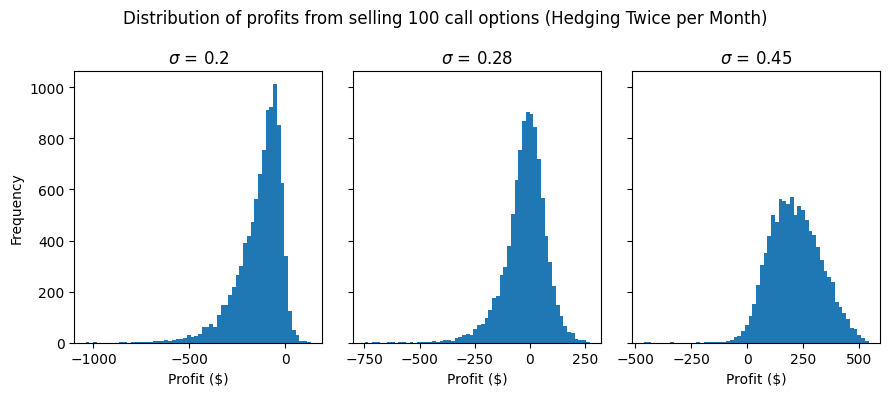

In [577]:
# --- run the three simulations ---------------------------------------------
results = []                          # hold rows for the summary table
fig, axes = plt.subplots(1, 3, figsize=(9, 4), sharey=True)

for j, sigma in enumerate(sigmas):
    # Black-Scholes premium (time-0)
    premium = bs_call(S0, K, sigma, t, r)

    # Simulate end-of-year prices
    pnl = bs_MC_call_sell_dynsigma(S0, K, sigma, t, r, n_sim=n_sim, n_hedges=n_hedges, P=premium, num_options=100, mu=0.0)

    # --- stats for the table
    expected   = pnl.mean()
    std_err    = pnl.std(ddof=1) / np.sqrt(n_sim)
    max_loss   = pnl.min()
    max_profit = pnl.max()

    results.append(
        [sigma, premium, expected, std_err, max_loss, max_profit]
    )

    # --- histogram subplot
    ax = axes[j]
    ax.hist(pnl, bins=60)
    ax.set_title(rf"$\sigma$ = {sigma}")
    ax.set_xlabel("Profit ($)")
    if j == 0:
        ax.set_ylabel("Frequency")

fig.suptitle("Distribution of profits from selling 100 call options (Hedging Twice per Month)")
plt.tight_layout()
plt.show()

In [578]:
# --- summary table ---------------------------------------------------
cols = [r"$\sigma$", "BS Price", "Expected Profit", "Std Error",
        "Max Loss", "Max Profit"]

summary = pd.DataFrame(results, columns=cols)

print("\nSummary statistics:")
print(summary.to_string(index=False, float_format="{:,.2f}".format))


Summary statistics:
 $\sigma$  BS Price  Expected Profit  Std Error  Max Loss  Max Profit
     0.20      2.33          -132.44       1.15 -1,040.74      133.43
     0.28      3.45           -21.28       0.94   -749.15      270.99
     0.45      5.81           214.75       1.13   -463.23      541.99


As expected, hedging helps to mitigate large losses but does not really affected the expected returns. In all, we see similar trends to before: if we underestimate the volatility (where its constant or dynamic), we will certainly lose money. If we overestimate volatility, we will gain money. The transition from losing to gaining money occurs right around the expected volatility value of 0.28.

As before, let's try for an array of $\sigma$'s used to price the value of the option for this dynamically-volatile stock.

In [579]:
sigma_hedge_vals = np.linspace(0.1,0.55,21) # the sigma assumed when computing deltas

In [580]:
S0, K, t, r = 35, 37.5, 1.0, 0.039
n_hedges = 24
n_sim = 1000

# --- run the simulations ---------------------------------------------
results = []                          # hold rows for the summary table

for sigma in sigma_hedge_vals:
    # Black-Scholes premium (time-0)
    premium = bs_call(S0, K, sigma, t, r)

    # Simulate end-of-year prices
    pnl = bs_MC_call_sell_dynsigma(S0, K, sigma, t, r, n_sim=n_sim, n_hedges=n_hedges, P=premium, num_options=100, mu=0.0)

    # --- stats for the table
    expected   = pnl.mean()
    std_err    = pnl.std(ddof=1) / np.sqrt(n_sim)
    max_loss   = pnl.min()
    max_profit = pnl.max()

    results.append(
        [sigma, premium, expected, std_err, max_loss, max_profit]
    )

results = np.asarray(results)

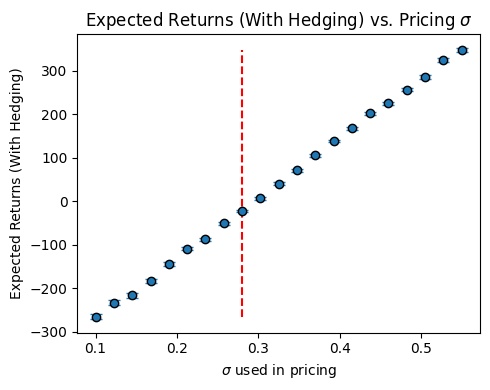

In [581]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.errorbar(sigma_hedge_vals, results[:,2], yerr=results[:,3], fmt='o', capsize=4, markeredgecolor='k')
ax.plot([0.28,0.28],[min(results[:,2]),max(results[:,2])],'r--')
ax.set_xlabel(r"$\sigma$ used in pricing")
ax.set_ylabel("Expected Returns (With Hedging)")
ax.set_title(r"Expected Returns (With Hedging) vs. Pricing $\sigma$")
plt.tight_layout()
plt.show()

Comparing this plot to the plot above, hedging really makes the results more predictable (note the strong linear trend here). Moreover, it is still clear that the $\sigma$ used in pricing really determines the outcome of the profits and losses.

### A simple hedging strategy when $\sigma$ is dynamic
For this hedging strategy, I will use the previous stock movement over a rolling window to try and estimate the volatility. Then, I will use the most recent sigma estimation in making my hedging move.

Note: for this problem, the dynamic sigma is chosen at random, therefore, estimating the most recent sigma is not meaningful as the next sigma is really unrelated to the rolling average. However, in a real life situation where sigma might have some 'momentum' or tomorrow's volatility can be correlated with last week's volatility, then this hedging stratedgy becomes more meaningful.

In [589]:
def bs_MC_call_sell_dynsigma_rt(S0, K, t, r, n_sim, n_hedges=252, window=10, P=0.0, num_options=1, mu=0.0):
    """
    Same idea as bs_MC_call_sell_dynsigma, but:
      • underlying follows stock_path_custom_sigma (sigma changes each step)
      • delta is recomputed at every hedge using the REALISED sigma over the
        last `window` steps (default 10 trading days).
    """
    dt = t / n_hedges
    S_paths = stock_path_custom_sigma(S0, t, r, mu, n_sim, n_hedges)

    discounted_stock_profits = []

    # --- step through hedge dates ------------------------------------------
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end   = S_paths[:, i + 1]
        tte     = t - i * dt                     # time-to-expiry

        # rolling sigma estimate using the *last* `window` steps
        if i < window:
            sigma_hat = np.full(n_sim, 0.28)     # not enough data yet, fall back to expected sigma
        else:
            log_rets = np.log(S_paths[:, i-window+1:i+1] / S_paths[:, i-window:i])
            # annualise realised stdev (assumes dt = 1/252 year)
            sigma_hat = log_rets.std(axis=1, ddof=1) * np.sqrt(252)
        
        # Black-Scholes delta with that sigma
        delta = bs_call_delta(S_start, K, sigma_hat, tte, r)

        # PV of stock profit for the interval
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)

    total_stock_profit = np.sum(discounted_stock_profits, axis=0)
    S_T          = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_T - K, 0)

    pnl = num_options * (P - call_payouts + total_stock_profit)
    return pnl

In [590]:
S0, K, T, r = 35, 37.5, 1.0, 0.039
sigma_quote  = 0.3 # average volatility between random walks from the first graph in this notebook
premium      = bs_call(S0, K, sigma_quote, T, r)   # price you receive

pnl = bs_MC_call_sell_dynsigma_rt(S0, K, T, r, n_sim=10000, n_hedges=252, window=10, P=premium, num_options=100, mu=0.0)

In [591]:
# quick results -------------------------------------------------------
print(f"Premium collected (BS)        : ${100*premium:,.2f}")
print(f"Mean P&L after hedging        : ${pnl.mean():,.2f}")
print(f"Std-dev of P&L                : ${pnl.std(ddof=1):,.2f}")
print(f"5% worst-case (VaR)           : ${np.quantile(pnl, 0.05):,.2f}")

Premium collected (BS)        : $372.49
Mean P&L after hedging        : $6.76
Std-dev of P&L                : $58.38
5% worst-case (VaR)           : $-91.89


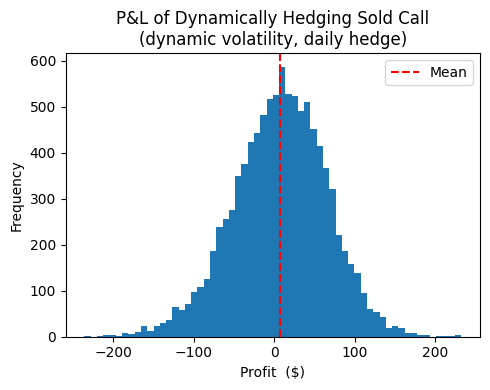

In [593]:
plt.figure(figsize=(5,4))
plt.hist(pnl, bins=60)
plt.axvline(pnl.mean(), color='r', linestyle='--', label='Mean')
plt.title("P&L of Dynamically Hedging Sold Call\n(dynamic volatility, daily hedge)")
plt.xlabel("Profit  ($)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

Finally, let's see how sensitive this hedging stratedy is to different sigma's used in pricing the option

In [594]:
sigma_hedge_vals = np.linspace(0.1,0.55,21) # the sigma assumed when computing deltas

In [595]:
S0, K, T, r = 35, 37.5, 1.0, 0.039
n_hedges = 252
n_sim = 1000

# --- run the simulations ---------------------------------------------
results = []                          # hold rows for the summary table

for sigma in sigma_hedge_vals:
    # Black-Scholes premium (time-0)
    premium = bs_call(S0, K, sigma, t, r)

    # Simulate end-of-year prices
    pnl = bs_MC_call_sell_dynsigma_rt(S0, K, T, r, n_sim=n_sim, n_hedges=n_hedges, window=10, P=premium, num_options=100, mu=0.0)

    # --- stats for the table
    expected   = pnl.mean()
    std_err    = pnl.std(ddof=1) / np.sqrt(n_sim)
    max_loss   = pnl.min()
    max_profit = pnl.max()

    results.append(
        [sigma, premium, expected, std_err, max_loss, max_profit]
    )

results = np.asarray(results)

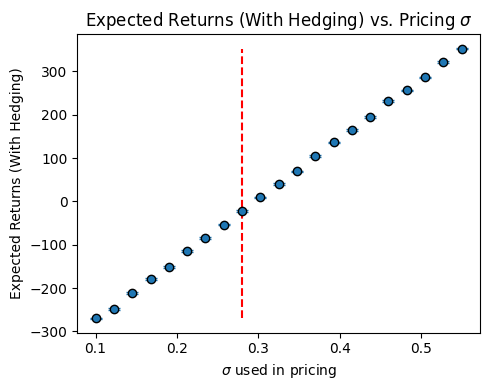

In [596]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.errorbar(sigma_hedge_vals, results[:,2], yerr=results[:,3], fmt='o', capsize=4, markeredgecolor='k')
ax.plot([0.28,0.28],[min(results[:,2]),max(results[:,2])],'r--')
ax.set_xlabel(r"$\sigma$ used in pricing")
ax.set_ylabel("Expected Returns (With Hedging)")
ax.set_title(r"Expected Returns (With Hedging) vs. Pricing $\sigma$")
plt.tight_layout()
plt.show()

Hedging, as before, make the outcome more predictable (note strong linear trend with small error bars). At the end of the day, the profit / loss margin boils down to what $\sigma$ you used in pricing the option.

If you were able to price the option with a higher volatility than in reality, then you will make money. However, if you price the option with a lower volatility than what is reflected in the stock movement, then you will lose money.

I expect that my strategy of calculating a rolling average of $\sigma$ would be useful in a real world scenerio where volatility of a stock is correlated to previous volatility and real world information. However, in this simple case where volatility is chosen by a random number generator, this stradegy provides little improvement from above.